In [1]:
!pip uninstall --yes --quiet osqp
!pip install scikit-survival

  Using cached osqp-0.6.2.post0-cp38-cp38-macosx_10_9_x86_64.whl (164 kB)


In [46]:
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
from tensorflow.keras.datasets import mnist

print("Using Tensorflow:", tf.__version__)

Using Tensorflow: 2.4.1


In [26]:
# Constants for development
FILESTOLOAD = 2888 # 2888 is all of them
imdim_from_preprocessing = 256 # must match opt.ImageSize in image preprocessing configuration files
imdim_for_network = 256
random_seed = 16

# Path to CSVs that connect patient id to slices and rfs label
zero_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_zero.csv"
zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'

# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
rfs_event = np.asarray(info.iloc[:, 3])
rfs_time = np.asarray(info.iloc[:, 4])

print(rfs_event.shape)
print(rfs_time[1])

(2888,)
0.6


100%|██████████| 2888/2888 [23:12<00:00,  2.07it/s]


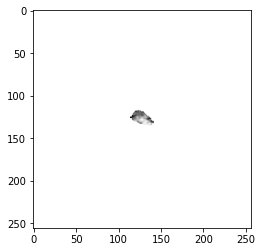

In [4]:
from tqdm import tqdm
from skimage.transform import resize

images = np.empty((1,imdim_for_network,imdim_for_network))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array - need to nothardcode this, square root?
        img_2D = np.reshape(img, (imdim_from_preprocessing,imdim_from_preprocessing))
        # Scale image to this dimension, smooth image with Gaussian filter, pads with the reflection of the vector
        # mirrored on the first and last values of the vector along each axis.
        img_final = resize(img_2D, (imdim_for_network, imdim_for_network), anti_aliasing=True, mode='reflect')
        # Not sure this next line is working, want an array with all the images as their own array in it
        img_final_3D = np.reshape(img_final, (1,) + img_final.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)
# Confirming images loaded in properly
plt.imshow(images[0], cmap='Greys')

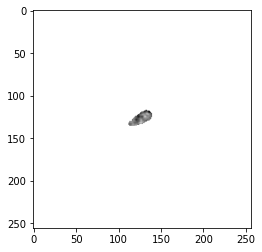

In [92]:
plt.imshow(images[11], cmap='Greys')

In [105]:
from patient_data_split import pat_train_test_split
# Training and testing split
split = 0.8
train_slice_indices, test_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], rfs_event[:FILESTOLOAD], split, random_seed)

train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

train_time = rfs_time[train_slice_indices]
train_event = rfs_event[train_slice_indices]
print("Training set: ", train_slices.shape)
print("Training time labels: ", train_time.shape)
print("Training event labels: ", train_event.shape)

test_slices = images[test_slice_indices,:,:]
test_slices = test_slices.squeeze() # Remove first dim of size 1

test_time = rfs_time[test_slice_indices]
test_event = rfs_event[test_slice_indices]
print("Testing set: ", test_slices.shape)
print("Testing time labels: ", test_time.shape)
print("Testing event labels: ", test_event.shape)

Training set:  (2557, 256, 256)
Training time labels:  (2557,)
Training event labels:  (2557,)
Testing set:  (686, 256, 256)
Testing time labels:  (686,)
Testing event labels:  (686,)


In [ ]:
# Convert rfs_event from numeric to boolean for use in sksurv
b_rfs_event = np.array(rfs_event, dtype=bool)
# Creating structured array for kaplan_meier_estimator
rfs_type = np.dtype([('Status','bool'), ('Time', 'f')])
rfs = np.empty(len(rfs_event),dtype=rfs_type)
rfs['Status'] = b_rfs_event
rfs['Time'] = rfs_time

rfs_train = rfs[train_slice_indices]
rfs_test = rfs[test_slice_indices]

train_1D = np.reshape(train_slices, (train_slices.shape[0], train_slices.shape[1]*train_slices.shape[2]))
test_1D = np.reshape(test_slices, (test_slices.shape[0], test_slices.shape[1]*test_slices.shape[2]))

print(train_1D.shape)
print(rfs_train.shape)
estimator = CoxPHSurvivalAnalysis().fit(train_1D, rfs_train)

risk_score = estimator.predict(train_1D)

# score = (train_1D, rfs_train)

# print(risk_score[1])

(12, 65536)
(12,)


In [199]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    
    # Initialize risk set 
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 64,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        # If image is 3D, reduce dimension to 2D
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch.
        
        Args:
            index - indices for the batch

        Returns:
            images - numpy array of images in the batch
            labels - dictionary of tuples (str, numpy array) with event, time, and riskset labels
        
        """
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        # Create dictionary of labels for the batch samples
        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`.
        
        Returns:
            images - tf.TensorShape, shape specification for images
            labels - dictionary of (str, tf.TensorShape), shape specification for labels
        """
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true.
    
    Args:
        risk_scores - tf.Tensor of predicted outputs of CoxPH, must be 2D
        mask - numpy array of boolean values with risk sets in rows, shape = (n_samples, n_samples)
        axis - int indicating which axis to perform sum across, should be axis samples is on (?)
        keepdims - bool, wheter to retain reduced dimensions in calculations
    
    Return:
        output - tf.Tensor logsumexp for risk scores
    """
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        # Input checking
        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        # Normalize risk scores
        predictions = safe_normalize(predictions)

        # More input checking
        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

In [29]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        # Combine labels and predictions into one dictionary
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        # Using c-index function sksurv
        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

In [160]:
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2


class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#         self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        # Store training checkpoint
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)
        # if this model was previously trained, start from last checkpoint
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                summary_ops_v2.graph(func.graph, step=0)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 200 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

In [31]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
#     tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
#     tf.keras.layers.Dense(1, activation='linear', name='dense_3')
# ])

# icc_train_fn = InputFunction(train_slices, train_time, train_event,
#                   drop_last=True,
#                   shuffle=True)

# icc_eval_fn = InputFunction(test_slices, test_time, test_event)

# icc_trainer = TrainAndEvaluateModel(
#     model=icc_model,
#     model_dir=Path("ckpts-icc-cnn"),
#     train_dataset=icc_train_fn(),
#     eval_dataset=icc_eval_fn(),
#     learning_rate=0.0003,
#     num_epochs=100,
# )

In [18]:
# print("Training set: ", x_train.shape)
# print("Training time labels:", time_train.shape)
# print("Training event labels:", event_train.shape)

# print("Testing set: ", x_test.shape)
# print("Testing time labels: ", time_test.shape)
# print("Testing event labels:", event_test.shape)

# plt.imshow(x_train[0])


In [32]:
# Polsterl tutorial model
icc_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

icc_train_fn = InputFunction(train_slices, train_time, train_event,
                  drop_last=False,
                  shuffle=True)

icc_eval_fn = InputFunction(test_slices, test_time, test_event)

icc_trainer = TrainAndEvaluateModel(
    model=icc_model,
    model_dir=Path("ckpts-icc-cnn"),
    train_dataset=icc_train_fn(),
    eval_dataset=icc_eval_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)

In [93]:
# Implementing DeepConvSurv model
dcs_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides = 3, activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides = 2, activation='relu', name='conv_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides = 2, activation='relu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

dcs_train_fn = InputFunction(train_slices, train_time, train_event,
                  batch_size=128,
                  drop_last=False,
                  shuffle=True)

dcs_eval_fn = InputFunction(test_slices, test_time, test_event)

dcs_trainer = TrainAndEvaluateModel(
    model=dcs_model,
    model_dir=Path("ckpts-dcs-cnn-200"),
    train_dataset=dcs_train_fn(),
    eval_dataset=dcs_eval_fn(),
    learning_rate=0.0003,
    num_epochs=200,
)

In [ ]:
dcs_trainer.train_and_evaluate()

In [184]:
# KT model 
# v1: Adding dropout layers between convolutional layers
# v2: changed first dropout to 0.3 from 0.5, changed to selu activation
# v3: train test split of 80-20
# v4: removed first dropout
# v6: first dropout 0.7, second 0.5
# v7: changed optimizer in TrainandEvaluate to SGD, 100 epochs, increased learning rate, decreased dropout to 0.5
kt_model = tf.keras.Sequential([
    tf.keras.Input(shape=(256,256,1)),
    tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides = 3, activation='selu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1'),
    tf.keras.layers.Dropout(0.7, seed=random_seed, name='drop_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides = 2, activation='selu', name='conv_2'),
    tf.keras.layers.Dropout(0.5, seed=random_seed, name='drop_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides = 2, activation='selu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='selu', name='dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_2')
])

kt_train_fn = InputFunction(train_slices, train_time, train_event,
                  batch_size=64,
                  drop_last=False,
                  shuffle=True)

kt_eval_fn = InputFunction(test_slices, test_time, test_event)

kt_trainer = TrainAndEvaluateModel(
    model=kt_model,
    model_dir=Path("ckpts-kt5-cnn-50"),
    train_dataset=kt_train_fn(),
    eval_dataset=kt_eval_fn(),
    learning_rate=0.0003,
    num_epochs=50,
)

In [185]:
kt_model.compile(
    optimizer='Adam', loss=CoxPHLoss()
)
kt_model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 84, 84, 32)        1600      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 42, 42, 32)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 42, 42, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 19, 19, 32)        25632     
_________________________________________________________________
drop_2 (Dropout)             (None, 19, 19, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 9, 9, 32)          9248      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 4, 32)        

In [192]:
import visualkeras

visualkeras.layered_view(kt_model).show()

AttributeError: module 'visualkeras' has no attribute 'graph_view'

In [93]:
# Implementing DeepConvSurv model
dcs_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides = 3, activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides = 2, activation='relu', name='conv_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides = 2, activation='relu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

dcs_train_fn = InputFunction(train_slices, train_time, train_event,
                  batch_size=128,
                  drop_last=False,
                  shuffle=True)

dcs_eval_fn = InputFunction(test_slices, test_time, test_event)

dcs_trainer = TrainAndEvaluateModel(
    model=dcs_model,
    model_dir=Path("ckpts-dcs-cnn-200"),
    train_dataset=dcs_train_fn(),
    eval_dataset=dcs_eval_fn(),
    learning_rate=0.0003,
    num_epochs=200,
)

In [162]:
kt_trainer.train_and_evaluate()

step 0: mean loss = 15.7132
Validation: loss = 3.8263, cindex = 0.4640
Validation: loss = 3.4315, cindex = 0.4615
Validation: loss = 3.1637, cindex = 0.4452
Validation: loss = 3.0712, cindex = 0.4386
Validation: loss = 3.0458, cindex = 0.4487
step 200: mean loss = 6.3152
Validation: loss = 2.9942, cindex = 0.4509
Validation: loss = 2.9678, cindex = 0.4540
Validation: loss = 2.9552, cindex = 0.4624
Validation: loss = 2.9410, cindex = 0.4668
Validation: loss = 2.9327, cindex = 0.4703
step 400: mean loss = 3.0472
Validation: loss = 2.9264, cindex = 0.4691
Validation: loss = 2.9169, cindex = 0.4755
Validation: loss = 2.9128, cindex = 0.4765
Validation: loss = 2.9087, cindex = 0.4771
Validation: loss = 2.9059, cindex = 0.4830
step 600: mean loss = 2.7759
Validation: loss = 2.9036, cindex = 0.4809
Validation: loss = 2.9011, cindex = 0.4764
Validation: loss = 2.9008, cindex = 0.4830
Validation: loss = 2.8985, cindex = 0.4866
Validation: loss = 2.8994, cindex = 0.4838
step 800: mean loss = 2.7

In [173]:
# KT model 2
ktv2_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(15, 15), strides = 3, activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5, seed=random_seed, name='drop_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(10, 10), strides = 2, activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5, seed=random_seed, name='drop_2'),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides = 2, activation='relu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.5, seed=random_seed, name='drop_3'),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides = 2, activation='relu', name='conv_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.5, seed=random_seed, name='drop_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(32, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

ktv2_train_fn = InputFunction(train_slices, train_time, train_event,
                  batch_size=64,
                  drop_last=False,
                  shuffle=True)

ktv2_eval_fn = InputFunction(test_slices, test_time, test_event)

ktv2_trainer = TrainAndEvaluateModel(
    model=kt_model,
    model_dir=Path("ckpts-ktv2.1-cnn-100"),
    train_dataset=ktv2_train_fn(),
    eval_dataset=ktv2_eval_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)


In [174]:
ktv2_trainer.train_and_evaluate()

step 0: mean loss = 2.2749
Validation: loss = 2.9867, cindex = 0.5390
Validation: loss = 2.9913, cindex = 0.5411
Validation: loss = 2.9823, cindex = 0.5347
Validation: loss = 3.0204, cindex = 0.5494
Validation: loss = 3.0183, cindex = 0.5474
step 200: mean loss = 2.4917
Validation: loss = 3.0433, cindex = 0.5481
Validation: loss = 3.0302, cindex = 0.5516
Validation: loss = 3.0601, cindex = 0.5515
Validation: loss = 3.0609, cindex = 0.5488
Validation: loss = 3.0038, cindex = 0.5570
step 400: mean loss = 2.4953
Validation: loss = 3.0081, cindex = 0.5505
Validation: loss = 3.0081, cindex = 0.5420
Validation: loss = 3.0286, cindex = 0.5507
Validation: loss = 3.0198, cindex = 0.5494
Validation: loss = 2.9794, cindex = 0.5303
step 600: mean loss = 2.5323
Validation: loss = 3.0284, cindex = 0.5438
Validation: loss = 3.0086, cindex = 0.5470
Validation: loss = 3.0189, cindex = 0.5460
Validation: loss = 3.0464, cindex = 0.5542
Validation: loss = 3.0410, cindex = 0.5551
step 800: mean loss = 2.51

In [72]:
# Trying with Resnet 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Preprocess images for ResNet before creating InputFunction object
res_train_slices = np.copy(train_slices)
# copies the image three times so it's mimicing RGB
res_train_slices =np.repeat(res_train_slices[..., np.newaxis], 3, -1)
res_train_slices = preprocess_input(res_train_slices)

res_test_slices = np.copy(test_slices)
res_test_slices = np.repeat(res_test_slices[..., np.newaxis], 3, -1)
res_test_slices = preprocess_input(res_test_slices)

# Set up model

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3))
x = base_model.output
x = Dense(32, activation='relu', name='dense_1')(x)
output = Dense(1, activation='linear', name='dense_2')(x)

res_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers: 
    layer.trainable = False

# Create InputFunction object
res_train_fn = InputFunction(res_train_slices, train_time, train_event,
                  drop_last=True,
                  shuffle=True)

res_eval_fn = InputFunction(res_test_slices, test_time, test_event,
                           drop_last=True,
                           shuffle=True)

# Set up Train and Eval model
res_trainer = TrainAndEvaluateModel(
    model=res_model,
    model_dir=Path("ckpts-res50-100"),
    train_dataset=res_train_fn(),
    eval_dataset=res_eval_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)

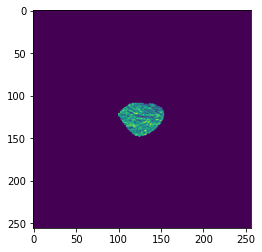

In [70]:
plt.imshow(res_train_slices[2, :, :, 2])

To obverse training, we can start TensorBoard.

Let the training begin…

In [ ]:
# # Not working yet
# res_trainer.train_and_evaluate()

In [99]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [198]:
import os
os.environ['TENSORBOARD_BINARY']='/Users/katyscott/Documents/ICC/venv/bin/tensorboard'

%tensorboard --logdir ckpts-kt6-cnn-100

Reusing TensorBoard on port 6007 (pid 5663), started 0:01:17 ago. (Use '!kill 5663' to kill it.)

In [35]:
icc_trainer.train_and_evaluate()

Latest checkpoint restored from ckpts-icc-cnn/ckpt-1.
step 0: mean loss = 8.5225
Validation: loss = 5.3744, cindex = 0.5323
Validation: loss = 4.0676, cindex = 0.5669
Validation: loss = 3.5734, cindex = 0.5585
Validation: loss = 3.5479, cindex = 0.5361
Validation: loss = 3.5841, cindex = 0.5481
step 200: mean loss = 4.1782
Validation: loss = 3.5742, cindex = 0.5479
Validation: loss = 3.6786, cindex = 0.5514
Validation: loss = 3.7784, cindex = 0.5581
Validation: loss = 3.8849, cindex = 0.5584
Validation: loss = 3.8933, cindex = 0.5575
step 400: mean loss = 2.2825
Validation: loss = 3.7537, cindex = 0.5675
Validation: loss = 3.6877, cindex = 0.5669
Validation: loss = 3.7728, cindex = 0.5516
Validation: loss = 3.9350, cindex = 0.5713
Validation: loss = 4.1185, cindex = 0.5787
step 600: mean loss = 2.1696
Validation: loss = 4.1863, cindex = 0.5740
Validation: loss = 4.2590, cindex = 0.5753
Validation: loss = 4.3108, cindex = 0.5908
Validation: loss = 4.3108, cindex = 0.5691
Validation: los

In [ ]:
# trainer.train_and_evaluate()

We can make a couple of observations:

1. The final concordance index on the validation data is close to the optimal value we computed above using the actual underlying risk scores.
2. The loss during training is quite volatile, which stems from the small batch size (64) and the varying number of uncensored samples that contribute to the loss in each batch. Increasing the batch size should yield smoother loss curves.

### Predicting Survival Functions

For inference, things are much easier, we just pass a batch of images and record the predicted risk score. To estimate individual survival functions, we need to estimate the baseline hazard function $h_0$, which can be done analogous to the linear Cox PH model by using [Breslow's estimator](https://www.jstor.org/stable/1402659).

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model.coxph import BreslowEstimator


class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

In [ ]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(x_train[..., np.newaxis]).batch(64)

predictor = Predictor(model, trainer.model_dir)
train_predictions = predictor.predict(train_pred_fn)

breslow = BreslowEstimator().fit(train_predictions, event_train, time_train)

Once fitted, we can use Breslow's estimator to obtain estimated survival functions for images in the test data. We randomly draw three sample images for each digit and plot their predicted survival function.

In [ ]:
sample = train_test_split(x_test, y_test, event_test, time_test,
                          test_size=30, stratify=y_test, random_state=89)
x_sample, y_sample, event_sample, time_sample = sample[1::2]

sample_pred_ds = tf.data.Dataset.from_tensor_slices(
    x_sample[..., np.newaxis]).batch(64)
sample_predictions = predictor.predict(sample_pred_ds)

sample_surv_fn = breslow.get_survival_function(sample_predictions)

plt.figure(figsize=(6, 4.5))
for surv_fn, class_label in zip(sample_surv_fn, y_sample):
    risk_group = risk_score_assignment.loc[class_label, "risk_group"]
    plt.step(surv_fn.x, surv_fn.y, where="post",
             color=f"C{class_label}", linestyle=styles[risk_group])

plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()

Solid lines correspond to images that belong to risk group 0 (with lowest risk), which the model was able to learn. Samples from the group with the highest risk are shown as dotted lines. Their predicted survival functions have the steepest descent, confirming that the model correctly identified different risk groups from images.

## Conclusion

We successfully built, trained, and evaluated a convolutional neural network for survival analysis on MNIST. While MNIST is obviously not a clinical dataset, the exact same approach can be used for clinical data. For instance, [Mobadersany et al.](https://www.pnas.org/content/115/13/E2970) used the same approach to predict overall survival of patients diagnosed with brain tumors from microscopic images, and [Zhu et al.](https://scholar.google.com/scholar?cluster=3381426605939025516) applied CNNs to predict survival of lung cancer patients from pathological images.